In [6]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, ZeroRClassifier, RandomClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myeval
import os

import plot_utils
importlib.reload(plot_utils)
import plot_utils as pu

import math
from collections import Counter

## Load the Movies dataset

In [7]:
movies_fname = os.path.join('input_data', 'movies.csv')
movies_table = MyPyTable().load_from_file(movies_fname, encode = 'cp1252')

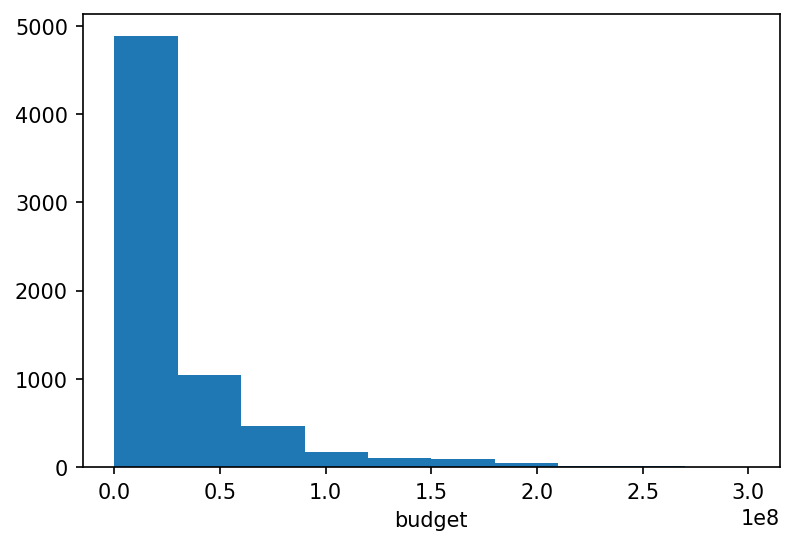

Removing Columns with Zero Values


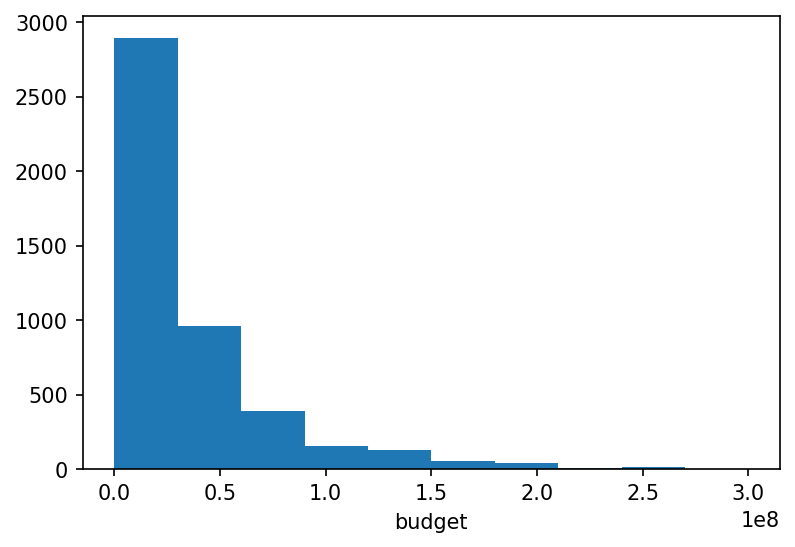

In [8]:
## visualize distribution of the budgets
## how many 0 values are there?
pu.plot_histogram(movies_table.get_column('budget'), 'budget')
print('Removing Columns with Zero Values')
movies_table.remove_rows_with_0_values(column = 'budget')
pu.plot_histogram(movies_table.get_column('budget'), 'budget')


# Budget 

## Histogram Analysis
- This hitogram demonstrates that there are less than 5,000 movies that have a budget of between 0-25,000,000
- Less than 100 movies had a budget 250,000,000-300,000,000




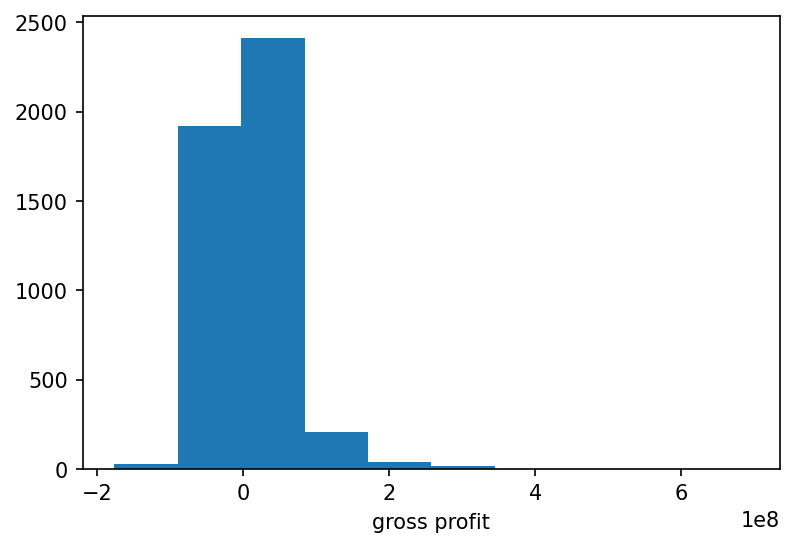

In [52]:
gross_profit = [movies_table.get_column('gross')[i] - movies_table.get_column('budget')[i] for i in range(len(movies_table.data))]
pu.plot_histogram(gross_profit, 'gross profit')


# Gross Profit
- The grossness of a movie is the total profit minus the budget

## Histogram Analysis 
- Less than 100 movies lost 200,000,000 
- Less than 2,000 movies broke even 
- Less than 500 movies made a profit of 100,000,000
- Less than 100 movies made a profit of 200,000,000


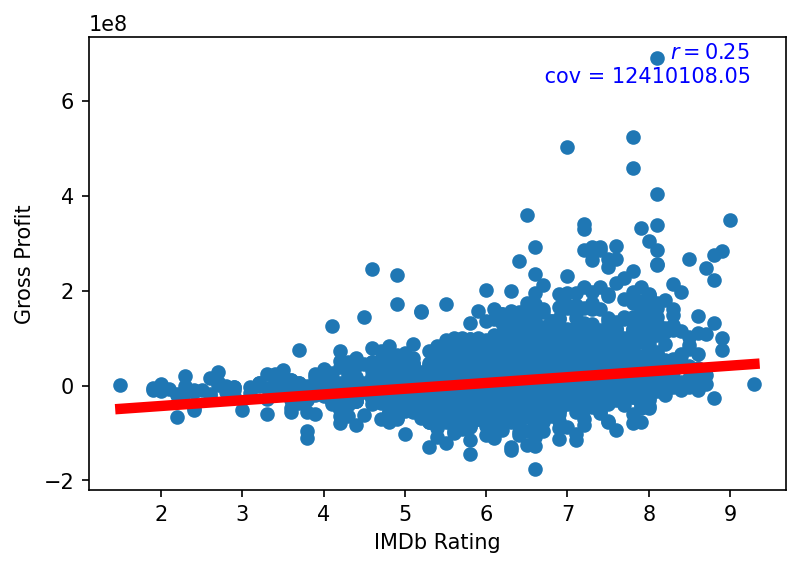

In [59]:
pu.plot_scatterplot(movies_table.get_column('score'), gross_profit, 'IMDb Rating', 'Gross Profit', linear_reg = True, legend_loc = 'upper right')

## IMDb Ratings and Gross Profit
- This graph demonstrates that the higher the rating the more profit that it is likely to make.  

## Check if movies made a profit or not

In [44]:
profitted = [0 if gross < 0 else 1 for gross in gross_profit]
movies_table.add_column(profitted, 'profitted')

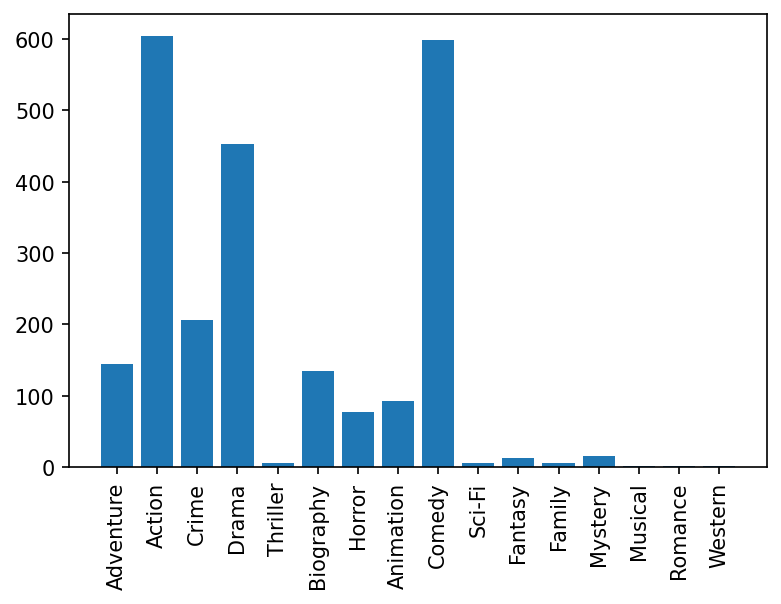

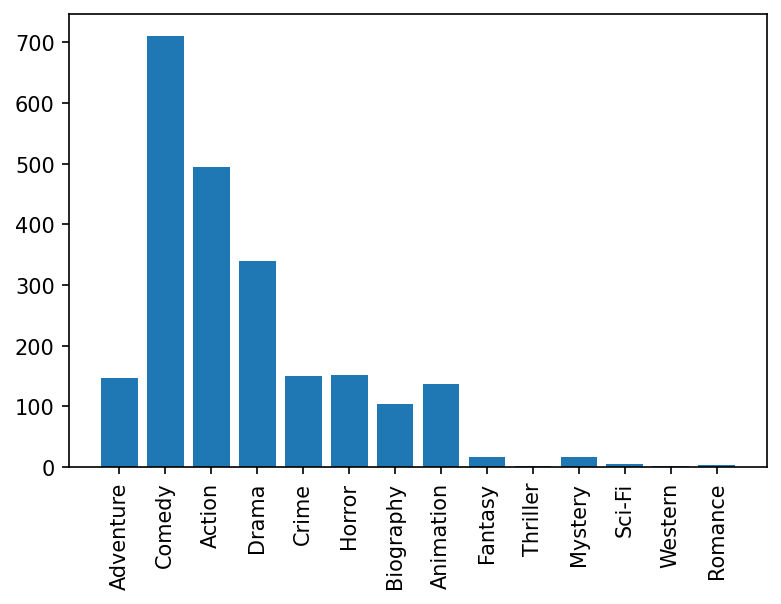

['Mystery',
 'Horror',
 'Comedy',
 'Biography',
 'Drama',
 'Romance',
 'Musical',
 'Animation',
 'Adventure',
 'Western',
 'Fantasy',
 'Family',
 'Crime',
 'Thriller',
 'Sci-Fi',
 'Action']

In [82]:
profit_groups = movies_table.group_by('profitted')
genre_idx = movies_table.column_names.index('genre')
for i in range(2):
    genre_cnt = Counter([x[genre_idx] for x in profit_groups[1][i]])
    pu.plot_bar_chart(labels = genre_cnt.keys(), y = genre_cnt.values())
genres


## Profit by Genre
- The dataset mostly contains Action and Comedy movies 
- Out of these movies 600/700 Comedy movies were profitable

The most common genre in the dataset is comedy and it also typically profits.

In [34]:
Counter(profitted)

Counter({1: 2278, 0: 2360})

In [92]:
Counter(movies_table.get_column('year'))

Counter({1986.0: 89,
         1987.0: 92,
         1988.0: 121,
         1989.0: 97,
         1990.0: 87,
         1991.0: 108,
         1992.0: 119,
         1993.0: 131,
         1994.0: 129,
         1995.0: 136,
         1996.0: 147,
         1997.0: 149,
         1998.0: 151,
         1999.0: 174,
         2000.0: 173,
         2001.0: 174,
         2002.0: 183,
         2003.0: 155,
         2004.0: 168,
         2005.0: 177,
         2006.0: 168,
         2007.0: 170,
         2008.0: 183,
         2009.0: 172,
         2010.0: 166,
         2011.0: 174,
         2012.0: 167,
         2013.0: 166,
         2014.0: 174,
         2015.0: 169,
         2016.0: 169})

## Movie Year

- 2008 and 2002 both had 183 movies made
- 1990 had 87 movies made



In [85]:
def test_folds(k, X_train_folds, X_test_folds, classifier, confusion_matrix = False):
    # evaluation metrics for each fold
    all_preds = []
    actuals = []
    for i in range(k):
        # get features and labels
        feature_cols = ['budget', 'genre', 'rating', 'score', 'star', 'director', 'writer']
        features = movies_table.get_key_columns(feature_cols)
        outcomes = profitted
        
        # get the train and test set for linear_regression
        X_train = [features[j] for j in range(len(features)) if j in X_train_folds[i]]
        y_train = [outcomes[j] for j in range(len(outcomes)) if j in X_train_folds[i]]
        X_test = [features[j] for j in range(len(features)) if j in X_test_folds[i]]
        y_test = [outcomes[j] for j in range(len(outcomes)) if j in X_test_folds[i]]

        # fit the linear regression model
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        all_preds.extend(y_pred) # add the predictions
        actuals.extend(y_test) # add the actuals

    if confusion_matrix:
        # print out the confusion matrix for the labels
        labels = list(set(actuals))
        print('Confusion matrix')
        matrix = myeval.confusion_matrix(all_preds, actuals, labels)
        print(myutils.format_confusion_matrix(matrix, labels))
       
        
    else:
        # compute accuracy for the train and test sets
        acc = myutils.compute_accuracy(all_preds, actuals)
        error = myutils.compute_accuracy(all_preds, actuals, error_rate = True)

        print('accuracy = {}, error rate = {}'.format(round(acc, 2), 
                                                                         round(error,2)))
       

In [40]:
k = 10
X_train_folds_strat, X_test_folds_strat = myeval.stratified_kfold_cross_validation(movies_table.data, 
                                                                                   profitted, n_splits=k)

In [86]:
print('-----------------------------------------------------')
print('Decision Tree - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
dt_class = MyDecisionTreeClassifier()
print('Cross Validation Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, dt_class)
# print('Confusion Matrix Results')
# test_folds(k, X_train_folds_strat, X_test_folds_strat, dt_class, confusion_matrix = True)

-----------------------------------------------------
Decision Tree - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.32, error rate = 0.68


In [87]:
print('-----------------------------------------------------')
print('Naive Bayes - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
nb_class = MyNaiveBayesClassifier()
print('Cross Validation Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, nb_class)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, nb_class, confusion_matrix = True)

-----------------------------------------------------
Naive Bayes - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.49, error rate = 0.51
Confusion Matrix Results
Confusion matrix
          0     1    Total    Recognition (%)
-----  ----  ----  -------  -----------------
0   |   355   363      718            49.4429
1   |  2005  1915     3920            48.852


In [88]:
print('-----------------------------------------------------')
print('K Nearest Neighbors - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
knn_class = MyKNeighborsClassifier()
print('Cross Validation Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, knn_class)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, knn_class, confusion_matrix = True)

-----------------------------------------------------
K Nearest Neighbors - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.57, error rate = 0.43
Confusion Matrix Results
Confusion matrix
          0     1    Total    Recognition (%)
-----  ----  ----  -------  -----------------
0   |  1368  1006     2374            57.6243
1   |   992  1272     2264            56.1837


## Classifiers

- Out of the three classifiers Decision Tree, Naive BAyes and K Nearest Neighbors, K Nearest Neighbors seemed to have the most chance of accuracy of .57 and the Decision Tree had the lowest amount of accuracy of .32